This notebook explores the ocean model simulation used as an input to the generator.
We make use of the Southern Ocean Regionally Refined Mesh v 2.1 run of the E3SM / MPAS-Ocean model, a 1000 year simulation of the ocean circulation, provided at a monthly resolution.
The notebook uses `dask` to chunk this dataset throughout the workflow to enable scalable computation.

In [1]:
import sys
import os
os.environ['USE_PYGEOS'] = '0'
import gc
import collections

import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams, cycler
from matplotlib import animation, rc
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import geopandas as gpd

import numpy as np
import xarray as xr
from xeofs.xarray import EOF
import rioxarray

import dask

import scipy
from scipy import signal
import cftime
from shapely.geometry import mapping
from xarrayutils.utils import linear_trend, xr_linregress
import pandas as pd

In [2]:
# File path directories

inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'
DIR_external = 'data/external/'
DIR_interim = 'data/interim/'

# DATASET FILEPATHS
# Ocean model output - E3SM (SORRMv2.1.ISMF), data received from Darin Comeau / Matt Hoffman at LANL
DIR_SORRMv21 = 'data/external/SORRMv2.1.ISMF/regridded_output/'

# INTERIM GENERATED FILEPATHS
DIR_SORRMv21_Interim = 'data/interim/SORRMv2.1.ISMF/iceShelves_dedraft/'

# DATA FILENAMES
FILE_SORRMv21 = 'Regridded_SORRMv2.1.ISMF.FULL.nc'

# Ice shelf basin/catchment definitions
FILE_iceShelvesShape = 'iceShelves.geojson'

In [3]:
SORRMv21 = xr.open_dataset(inDirName+DIR_SORRMv21+FILE_SORRMv21, chunks={"Time":36})

ICESHELVES_MASK = gpd.read_file(inDirName+DIR_external+FILE_iceShelvesShape)
icems = ICESHELVES_MASK.to_crs({'init': 'epsg:3031'});
crs = ccrs.SouthPolarStereo();

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [5]:
flux = SORRMv21.timeMonthly_avg_landIceFreshwaterFlux
# ssh = SORRMv21.timeMonthly_avg_ssh

### Temporal Standard Deviation

In [9]:
# Standard deviation in time
flux_std = flux.std('Time').compute()
flux_std.where(flux_std!=0).plot()

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


### Temporal Mean

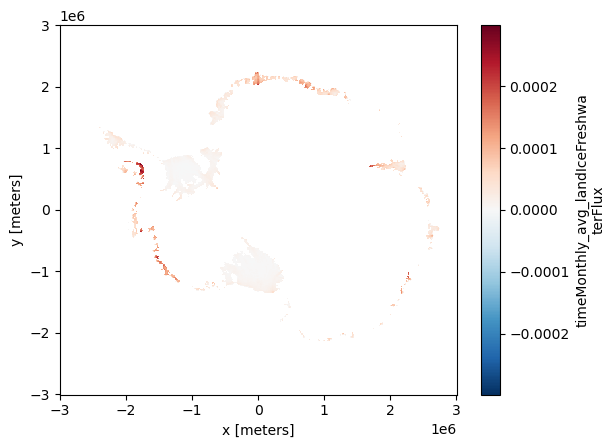

In [18]:
# Time mean
flux_tmean = flux.mean('Time').compute()
flux_tmean.where(flux_std!=0).plot()

### Cumulative melt rate (across the ice sheet)

In [19]:
flux_ts = flux.sum(['x','y']).compute()

Text(0.5, 1.0, 'Freshwater Flux - AIS Cumulative')

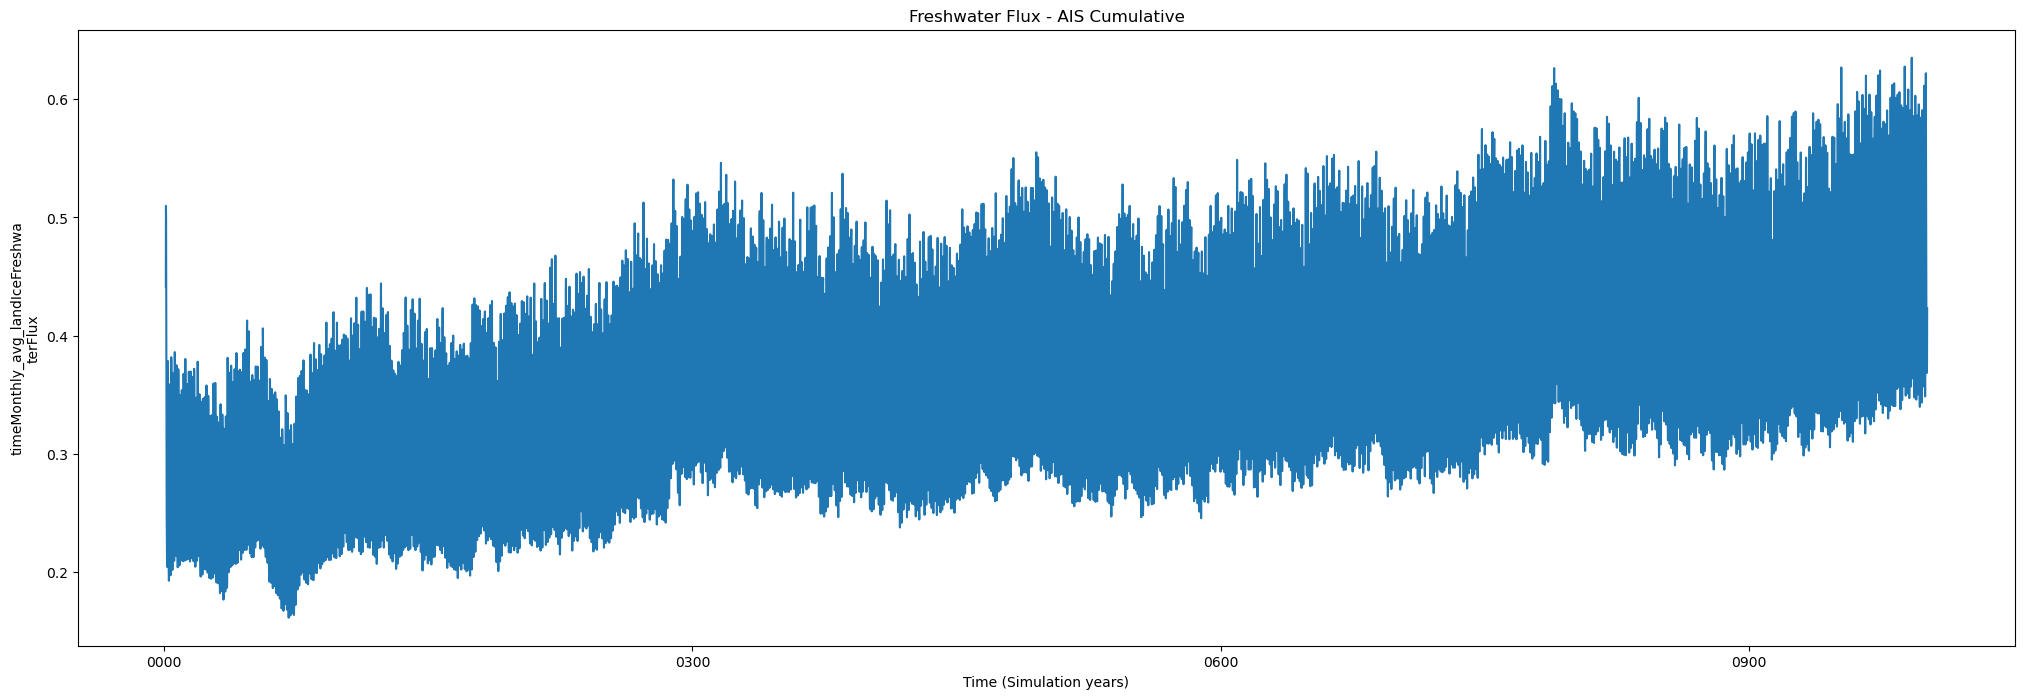

In [22]:
plt.figure(figsize=(25,8))
flux_ts.plot()
plt.xlabel('Time (Simulation years)')
plt.title('Freshwater Flux - AIS Cumulative')

### Mean freshwater flux in each catchment